In [ ]:
!pip install rouge-score
!pip install langchain langchain-openai faiss-cpu tiktoken
!pip install chromadb
!pip install sentence-transformers
!pip install PyPDF2
!pip install ipywidgets
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.vectorstores.chroma import Chroma
from PyPDF2 import PdfReader
import keras
import keras_nlp
import tensorflow as tf
from rouge_score import rouge_scorer
from langchain.embeddings import SentenceTransformerEmbeddings
import time
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import sentencepiece
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

os.environ["KERAS_BACKEND"] = "jax"
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.00'

2024-04-23 22:49:17.436796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 22:49:17.436910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 22:49:17.562215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def create_document(pdf_path,start_idx=None, end_idx=None):
    '''
    Extracts text from a pdf and Creates a Langchain Document object

    Parameters:
    pdf_path (str): File path of the pdf to be placed into knowledge base
    start_idx (int): Deletes the first n characters of the document if irrelavent
    end_idx (int): Deletes the last n characters of the document if irrelavent

    Returns:
    doc (Document): The pdf text as a Langchain Document Object
    '''
    text = ''
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        for page in reader.pages:
            text += page.extract_text()

    if start_idx and end_idx:
        text=text[start_idx:end_idx]

    doc = Document(page_content=text,metadata={"source":pdf_path})

    return doc

def split_text(documents: list[Document]):
    '''
    Converts Langchain Document objects into many smaller Document objects
    of chunked text

    Parameters:
    documents (list[Document]): list of Langchain Document objects to be chunked

    Returns:
    chunks (list[Document]): chunked text as Langchain Document objects
    '''

    #define hyperparameters for how to split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        #number of characters per chunk
        chunk_size=300,
        #make chunks overlap to hopefully capture important info
        chunk_overlap=100,
        length_function=len,
        add_start_index=True,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")


    return chunks

def split_df_RAG(df,path,RAG_proportion=.5):
    '''
    To reduce training time, can place some of training set into RAG system
    and exclude from training. This function randomly transforms some
    observations into RAG Documents.

    Parameters:
    df (pd.DataFrame): dataFrame with <QUESTION> column and <RESPONSE> column
    path (str): location of data path for data in df
    RAG_proportion (float): percentage of observations to transfer to RAG

    Returns:
    doc (Langchain Document): Un-chunked Document for RAG
    df (pd.DataFrame): remaining observations to keep for training set
    '''

    #get random indices to keep for RAG
    random_indices = np.random.permutation(df.shape[0])
    RAG_idx = random_indices[:int(df.shape[0]*RAG_proportion)]
    #get corresponding training set indices
    remaining_idx = random_indices[int(df.shape[0]*RAG_proportion):]
    #convert RAG examples into a document
    RAG_examples = df.iloc[RAG_idx]
    RAG_text = (RAG_examples['<QUESTION>']+' \n' +RAG_examples['<RESPONSE>']).values
    RAG_text = ' '.join(RAG_text)
    doc = Document(page_content=RAG_text,metadata={"source":path})
    #remove the RAG examples from the training set
    df = df.iloc[remaining_idx]

    return doc,df

In [ ]:
np.random.seed(1)
df1_path = '/kaggle/input/python-code-questions/python_code_questions.jsonl'
df1 = pd.read_json(df1_path, lines=True)
RAG1, df1 = split_df_RAG(df1,df1_path,.9)

df2_path = '/kaggle/input/python-conceptual-q/Python_Conceptual_Questions.jsonl'
df2 = pd.read_json(df2_path, lines=True)
RAG2, df2 = split_df_RAG(df2,df2_path,.9)

df3_path = '/kaggle/input/flytech-pythoncodes-25k-dataset/python-codes-25k.jsonl'
df3 = pd.read_json(df3_path, lines=True)
df3=df3[['instruction','output']]
df3.rename(columns={'instruction': '<QUESTION>', 'output': '<RESPONSE>'}, inplace=True)
RAG3, df3 = split_df_RAG(df3,df3_path,.9)

df4_path = '/kaggle/input/mbppjsonl/mbpp.jsonl'
df4 = pd.read_json(df4_path, lines=True)
df4=df4[['text','code']]
df4.rename(columns={'text': '<QUESTION>', 'code': '<RESPONSE>'}, inplace=True)
RAG4, df4 = split_df_RAG(df4,df4_path,.9)

#combine into one dataset
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [ ]:
#Load Documents for Knowledge Base
documents=[RAG1,RAG2,RAG3,RAG4]

start_time = time.time()
for dirname, _, filenames in os.walk('/kaggle/input/knowledge-base'):
    counter=0
    for filename in filenames:
        counter+=1
        print("Loading textbook number {}".format(counter))
        doc_path = os.path.join(dirname, filename)
        documents.append(create_document(doc_path))

#Split document into multiple objects
chunks = split_text(documents)
end_time = time.time()
print("\nElapsed time:", end_time-start_time, "seconds")

Loading textbook number 1
Loading textbook number 2
Loading textbook number 3
Split 7 documents into 92885 chunks.

Elapsed time: 74.79901957511902 seconds


In [ ]:
#Use embedding model from HF
embeddings = SentenceTransformerEmbeddings(model_name = "avsolatorio/GIST-small-Embedding-v0")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
%%capture

#load chroma db instead of constructing it again (faster)
vectordb = Chroma(persist_directory="/kaggle/input/vectordb/kaggle/working/vectordb", embedding_function=embeddings)

# #save database for future into output folder. Use as .zip file. If created db instead of loading it, change path
!zip -r vectordb.zip /kaggle/input/vectordb/kaggle/working/vectordb

In [ ]:
#Now that we have an embedding model, need to embed all of the queries in the training and testing datasets
all_context=[]

for row in range(df.shape[0]):
    #for memory purposes, grab only top relevant chunk
    all_context.append(vectordb.similarity_search_with_relevance_scores(df['<QUESTION>'][row],k=1)[0][0].page_content)
#create a new column in the dataset
df['<CONTEXT>']=all_context

In [ ]:
#Separate the ground-truth response labels from the dataset
X = df.drop(columns=['<RESPONSE>'])
y = df['<RESPONSE>']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=600, random_state=100)

#Add context to training and testing sets
X_train_with_RAG = list('<CONTEXT>:\n' + X_train['<CONTEXT>'] + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ X_train['<QUESTION>'] + '\n\n<RESPONSE>:\n'+y_train)
X_test_with_RAG = list('<CONTEXT>:\n' + X_test['<CONTEXT>'] + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ X_test['<QUESTION>'] + '\n\n<RESPONSE>:\n')
X_val_with_RAG = list('<CONTEXT>:\n' + X_val['<CONTEXT>'] + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ X_val['<QUESTION>'] + '\n\n<RESPONSE>:\n')
y_test = y_test.reset_index()
y_test = y_test['<RESPONSE>']
y_val = y_val.reset_index()
y_val = y_val['<RESPONSE>']

#to measure if RAG helps on its own, get same training set but without context from RAG
X_test_pre_RAG = X_test['<QUESTION>'].to_list()
y_test_list = y_test.tolist()
for idx in range(len(X_test_pre_RAG)):
    X_test_pre_RAG[idx] = "<QUESTION>:\n\n" + X_test_pre_RAG[idx] + "\n\n<RESPONSE>:\n"

In [ ]:
#Load the Gemma model with specified hyperparameters

#set seed for reproducability
tf.random.set_seed(100)

#load the instruct version of Gemma
model = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")
#rank 16 LoRA
model.backbone.enable_lora(rank=16)
#Only allow model to look back 305 characters for memory purposes
model.preprocessor.sequence_length = 375
#define the weight decay / learning-rate for the optimizer (AdamW is used for this notebook)
optimizer = keras.optimizers.AdamW(
    learning_rate=8.5e-4,
    weight_decay=0.0005,
    )

#Exclude layernorm and bias terms from decay to speed up training and reduce memory consumption
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

#compile the model by specifying the loss and other metrics we may want to track
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [ ]:
def generate_test_set_responses(features_test):
    '''
    Get model's answers for queries listed in the test set for evaluation metrics

    Parameters:
    features_test (list): list of prompts to ask model

    Returns:
    responses (list): list of responses from model
    '''
    responses=[]
    #for each prompt in the list
    for idx in range(len(features_test)):
    #generate the response
        responses.append(model.generate(features_test[idx], max_length=512))
    #update user
        if(idx%100==0):
            print("Finished number {}".format(idx))

    #We don't need to return the question that is kept when calling model.generate()
    keyword_length = len("<RESPONSE>:\n")
    #for each of the responses
    for idx in range(len(responses)):
    #find where response begins, and start after "<RESPONSE>:\n" substring
        try:
            start_idx = responses[idx].index("<RESPONSE>:")
            responses[idx]=responses[idx][(start_idx+keyword_length):]
        except:
            pass

    return responses

In [ ]:
def get_rogue_metrics(y_hat,y_true,rouge_type):
    '''
    Calculate rogue score recall, precision, and f-measure for a given list
    of model responses and ground-truth labels

    Parameters:
    y_hat (list): list of generated responses from model
    y_true (list): list of ground-truth response labels
    rouge_type (str): one of 'rougeL' or 'rougeN' where N is an integer

    Returns:
    all_recall (list): rogue score recall for each response, ground-truth label pair
    all_precision (list): rogue score precision for each response, ground-truth label pair
    all_f_measure (list): rogue score f-measure for each response, ground-truth label pair
    '''
    scorer = rouge_scorer.RougeScorer([rouge_type])
    all_recall = [scorer.score(y_hat[idx],y_true[idx])[rouge_type].recall for idx in range(len(y_hat))]
    all_precision = [scorer.score(y_hat[idx],y_true[idx])[rouge_type].precision for idx in range(len(y_hat))]
    all_f_measure = [scorer.score(y_hat[idx],y_true[idx])[rouge_type].fmeasure for idx in range(len(y_hat))]

    return all_recall, all_precision, all_f_measure

In [ ]:
#assess the performance without RAG and without fine-tuning
y_hat_pre_RAG = generate_test_set_responses(X_test_pre_RAG)
recall_pre, precision_pre, f_measure_pre = get_rogue_metrics(y_hat_pre_RAG, y_test_list,'rougeL')

I0000 00:00:1713912854.691156      28 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713912854.765801      28 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Finished number 0
Finished number 100
Finished number 200
Finished number 300


In [ ]:
print("Mean rogueL recall pre-RAG is {}".format(round(np.mean(recall_pre),3)))
print("Mean rogueL precision pre-RAG is {}".format(round(np.mean(precision_pre),3)))
print("Mean rogueL fmeasure pre-RAG is {}".format(round(np.mean(f_measure_pre),3)))

Mean rogueL recall pre-RAG is 0.144
Mean rogueL precision pre-RAG is 0.488
Mean rogueL fmeasure pre-RAG is 0.193


In [ ]:
#assess the performance with RAG but without fine-tuning
y_hat_post_RAG = generate_test_set_responses(X_test_with_RAG)
recall_post, precision_post, f_measure_post = get_rogue_metrics(y_hat_post_RAG, y_test_list,'rougeL')

Finished number 0
Finished number 100
Finished number 200
Finished number 300


In [ ]:
print("Mean rogueL recall post-RAG is {}".format(round(np.mean(recall_post),3)))
print("Mean rogueL precision post-RAG is {}".format(round(np.mean(precision_post),3)))
print("Mean rogueL fmeasure post-RAG is {}".format(round(np.mean(f_measure_post),3)))

Mean rogueL recall post-RAG is 0.21
Mean rogueL precision post-RAG is 0.429
Mean rogueL fmeasure post-RAG is 0.234


In [ ]:
def ask_query(query):
    '''
    Given a query, gather appropriate context and pass both into model
    to get a response

    Parameters:
    query (str): question to ask the model

    Returns:
    return_str (str): response from the model
    '''
    #for memory purposes, our model does not look back too many characters.
    #therefore, just grab top 1 chunk most relevant to query
    context = vectordb.similarity_search_with_relevance_scores(query,k=1)[0]

    #prompt engineering: add the conext to the question to make the prompt
    entire_query = '<CONTEXT>:\n' + context[0].page_content + '\n\n<QUESTION>: Answer this <QUESTION> using the <CONTEXT> from above.\n\n'+ query + '\n\n<RESPONSE>:\n'
    #feed into model
    return_str = model.generate(entire_query,max_length=512)
    #if there is a relevant document, tell the user where the context was located
    if context[1] > .7:
        return_str += '\n\nContext taken from '+ context[0].metadata['source'].rsplit('/', 1)[-1]
    else:
    #if no relevant documents, still keep in prompt but warn the user about this
        return_str += '\n\n Warning: No relevant context for question in database.'

    #only return the actual response (not the question and context too)
    return_str = return_str.rsplit('\n\n<RESPONSE>:\n', 1)[-1]
    return(return_str)

In [ ]:
#if we are loading a model that is already fine-tuned, run the below line
model.backbone.load_lora_weights("/kaggle/input/fine-tuned-pygem-weights/PyGEM_lora_weights_all_saved.lora.h5")
#if we trained the model, save progress by running line below. Here we run the line to save to Kaggle output folder
model.backbone.save_lora_weights("/kaggle/working/PyGEM_lora_weights_all_saved.lora.h5")
#alternatively, can save the entire keras model
model.save('PyGEM.keras')

In [ ]:
#assess the performance with RAG and with fine-tuning
y_hat = generate_test_set_responses(X_test_with_RAG)
recall_ft, precision_ft, f_measure_ft = get_rogue_metrics(y_hat, y_test_list,'rougeL')

Finished number 0
Finished number 100
Finished number 200
Finished number 300


In [ ]:
print("Mean rogueL recall post-Fine-Tuning is {}".format(round(np.mean(recall_ft),3)))
print("Mean rogueL precision post-Fine-Tuning is {}".format(round(np.mean(precision_ft),3)))
print("Mean rogueL fmeasure post-Fine-Tuning is {}".format(round(np.mean(f_measure_ft),3)))

Mean rogueL recall post-Fine-Tuning is 0.44
Mean rogueL precision post-Fine-Tuning is 0.433
Mean rogueL fmeasure post-Fine-Tuning is 0.405


In [ ]:
#ROUGE-2 Scores
recall_pre_2, precision_pre_2, f_measure_pre_2 = get_rogue_metrics(y_hat_pre_RAG, y_test_list,'rouge2')
recall_post_2, precision_post_2, f_measure_post_2 = get_rogue_metrics(y_hat_post_RAG, y_test_list,'rouge2')
recall_ft_2, precision_ft_2, f_measure_ft_2 = get_rogue_metrics(y_hat, y_test_list,'rouge2')

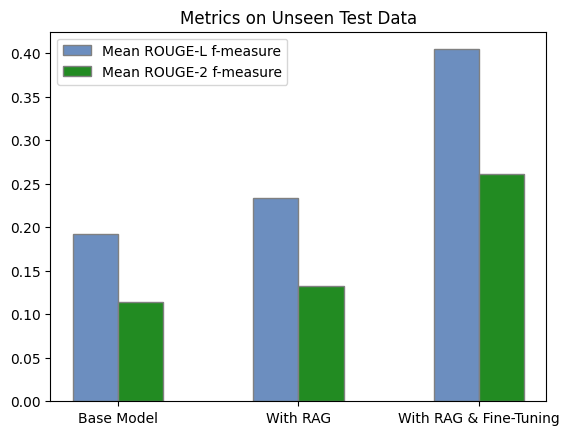

In [ ]:
# Plot change in metrics after incorporating RAG and after fine-tuning
categories = ['Base Model', 'With RAG', 'With RAG & Fine-Tuning']
bars1 = [np.mean(f_measure_pre), np.mean(f_measure_post), np.mean(f_measure_ft)]
bars2 = [np.mean(f_measure_pre_2), np.mean(f_measure_post_2), np.mean(f_measure_ft_2)]


r1 = np.arange(len(categories))
r2 = [x + 0.25 for x in r1]  # Adding 0.25 to each value in r1 to create space between bars
plt.bar(r1, bars1, color='#6c8ebf', width=0.25, edgecolor='grey', label='Mean ROUGE-L f-measure')
plt.bar(r2, bars2, color='#228B22', width=0.25, edgecolor='grey', label='Mean ROUGE-2 f-measure')
plt.xticks([r + 0.125 for r in range(len(categories))], categories)

plt.legend()
plt.title("Metrics on Unseen Test Data")
plt.show()

In [ ]:
# Define custom CSS style/preferences below

custom_css = """
/* Style for output area */
.output-area {
    margin-top: 20px;
    padding: 10px;
    background-color: #f0f0f0;
}

/* Style for loading spinner */
.spinner {
    border: 3px solid #f3f3f3; /* Light grey */
    border-top: 3px solid #3498db; /* Blue */
    border-radius: 50%;
    width: 30px; /* Adjust width */
    height: 30px; /* Adjust height */
    animation: spin 1s linear infinite; /* Apply animation */
    margin: auto;
    margin-top: 20px;
}

/* Keyframe animation for spinning */
@keyframes spin {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}
"""

# Apply custom CSS styles
display(HTML("<style>" + custom_css + "</style>"))

In [ ]:
import ipywidgets
#Create text box so user can ask question
text_box = widgets.Text(
    value='',
    placeholder='Ask PyGEM your question here',
    description='Question:',
    disabled=False,
    layout=widgets.Layout(width='500px'),
    style={'description_width': 'initial'}
)

#Create "Ask" button to submit query to model
submit_button = widgets.Button(
    description='Ask',
    disabled=False,
    button_style='success',
    tooltip='Ask'
)

output_area = widgets.Output()

#Define response function
def respond_to_question(sender):
    question = text_box.value

    text_box.value = ''

    #Display loading spinner while model is generating a response
    with output_area:
        output_area.clear_output()
        display(HTML('<div class="spinner"></div>'))

    #Generate the model's response
    response = ask_query(question)

    #Display the model's response to the user
    with output_area:
        output_area.clear_output()
        print(f"Question: {question}\n")
        print(f"Response: {response}\n")

#Assign response function to button click event
submit_button.on_click(respond_to_question)

#Define PyGEM logo
image_path = '/kaggle/input/pygem-logo/logo1.png'
image_widget = widgets.Image(value=open(image_path, 'rb').read(), format='png', width=400)

#Define PyGEM's intro
text_widget = widgets.HTML(
    value="<h2> <span style='margin-left: 100px;'>Hi! My name is PyGEM.<br><br> I was trained using Google's Gemma models to<br> answer any questions you have about the Python<br> programming language. Ask away!</h2>",
    layout=widgets.Layout(margin='25px 0')
)

#Display everything
container = widgets.VBox([image_widget,text_widget,widgets.HBox([text_box, submit_button]), output_area],)
display(container)